## Getting Started

The data for this exercise is a small SQLite database containing roughly a dozen tables. If you are not familiar with the SQLite database, it uses a fairly complete and standard SQL syntax, though does not many advanced analytics functions. Consider it just a remote datastore for storing and retrieving data from. 

![](db-diagram.png)

## Use this data set to answer the questions below.

In [5]:
import sqlite3
import pandas 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
import datetime as dt
import pandas as pd
plt.style.use('ggplot')
import numpy as np; import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
con = sqlite3.connect("C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/sqlite/chinook.db")

### 1. How many different customers are there? (Example)

In [7]:
%%sql
select count(*) as count_customers, 
       count(distinct email) as count_uniq_emails
from customers

ERROR:root:Cell magic `%%sql` not found.


or alternatively...

In [8]:
query = """
select count(*) as count_customers, 
       count(distinct email) as count_uniq_emails
from customers
"""
pandas.read_sql(query, con=con)

,count_customers,count_uniq_emails
0,59,59


In [8]:
query = """
select count(distinct customerid) as no_of_customers from customers
"""
pandas.read_sql(query, con=con)

,no_of_customers
0,59


### 2. How long is the longest track in minutes?

In [9]:
query = """
select trackid, name, (max(Milliseconds)/1000)/60 as longest_track from tracks

"""
pandas.read_sql(query, con=con)

,TrackId,Name,longest_track
0,2820,Occupation / Precipice,88


### 3. Which genre has the shortest average track length?

In [16]:
query = """
select (avg(milliseconds)/1000)/60 as shortest_avg_length_in_min, tracks.Genreid, genres.name
from tracks inner join genres on tracks.genreid = genres.genreid
group by tracks.genreid
order by shortest_avg_length_in_min
limit 1
"""
pandas.read_sql(query, con=con)

,shortest_avg_length_in_min,GenreId,Name
0,2.244058,5,Rock And Roll


### 4. Which artist shows up in the most playlists?

In [17]:
query = """
select count(artists.name) as most_popular_artist_count, artists.Name as artist_naam, 
playlists.name as playlist_naam
from artists inner join albums on artists.artistid = albums.artistid 
inner join tracks on albums.albumid = tracks.albumid
inner join playlist_track on tracks.trackid = playlist_track.trackid
inner join playlists on playlist_track.playlistid = playlists.playlistid
group by playlists.name
order by most_popular_artist_count desc
limit 1

"""
pandas.read_sql(query, con=con)

,most_popular_artist_count,artist_naam,playlist_naam
0,6580,Philip Glass Ensemble,Music


### 5. What was the most popular album among these customers?

In [18]:
query = """
select Album_name, max(count) 
from
(select al.Title as Album_name, al.Title, count(i.CustomerId) as count from albums al
inner join tracks tr on al.Albumid = tr.Albumid
inner join invoice_items it on tr.Trackid = it.Trackid
inner join invoices i on it.Invoiceid = i.Invoiceid
group by al.albumid)
"""
pandas.read_sql(query, con=con)

,Album_name,max(count)
0,Minha Historia,27


### 6. What is the correlation between the length of a track and its price?

In [19]:
track_facts = pandas.read_csv("C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/track_facts.csv")

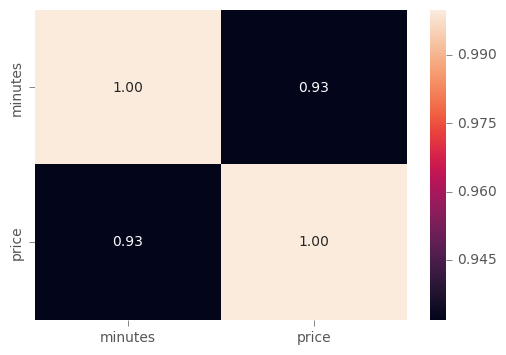

In [20]:
def plot_correlation_using_heatmap(data, xticklabels, yticklabels):
    """ The function takes in a pandas dataframe, x_labels and y_labels for the correlation plot as parameters
        - displays Pearson Correlation values using Heatmap
    """
    sns.heatmap(data.corr(), 
                xticklabels = xticklabels,
                yticklabels = yticklabels,
                annot=True, fmt=".2f")

    plt.show()
    
plot_correlation_using_heatmap(track_facts, xticklabels = ['minutes', 'price'], yticklabels = ['minutes', 'price'])

#### A person-correlation coefficient of 0.93 indicates that length of the track and price have a strong positive correlation

### 7. Do any seasonal patterns occur in purchases (invoices)?

In [21]:
orders = pandas.read_csv("C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/orders.csv")
orders['invoice_date'] = pandas.to_datetime(orders['invoice_date'], infer_datetime_format = True)
orders.set_index('invoice_date', drop = True, inplace=True)

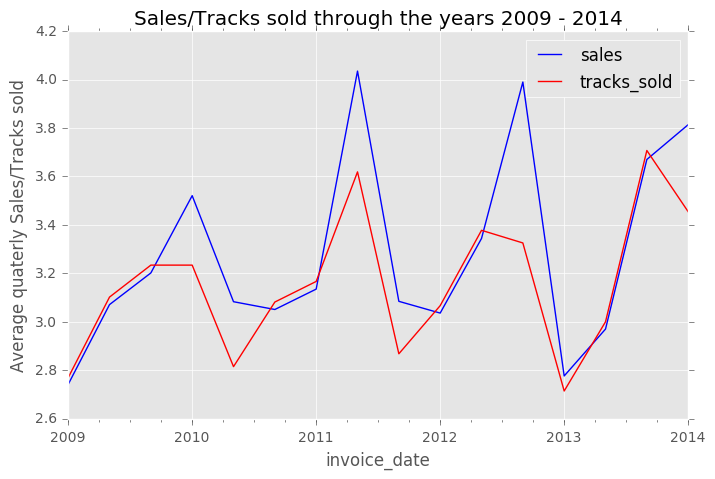

In [22]:
#Resampling the Data to check if there is a monthly, quaterly or a bi-yearly seasonality
def plot_line_graph_for_resampled_data(data, resampling_by = None):
    """ The function accepts a pandas dataframe and a resampling period as arguments
        plots a line graph on the resampled (averaged)data
    """
    df_avg = data.resample(resampling_by).mean()
    df_avg['sales'].plot(figsize=(8,5), color = 'blue')
    df_avg['tracks_sold'].plot(figsize=(8,5), color = 'red' )
    plt.legend()
    plt.ylabel('Average quaterly Sales/Tracks sold')
    plt.title('Sales/Tracks sold through the years 2009 - 2014')
    plt.show()

#Resampling the orders data by the mean on each quarter
plot_line_graph_for_resampled_data(orders, resampling_by = '4m')

#### There seems to be no consistent pattern in monthly, quarterly or bi-yearly sales, there seems to be a cyclic rise and fall in sales but, the rise and fall are not entirely dependent on the time of the year

### 8. How would you tell whether a new Rock song is an outlier in terms of track length?
*use track_facts*

In [23]:
track_facts = pandas.read_csv("C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/track_facts.csv")
rock_track_length_data = track_facts[track_facts['genre'] == 'Rock']['minutes']

The lower bound for this data is --> 0.80 minutes, any data point less than this value is considered an Outlier
The upper bound for this data is --> 8.00 minutes, any data point greater than this value is considered an Outlier


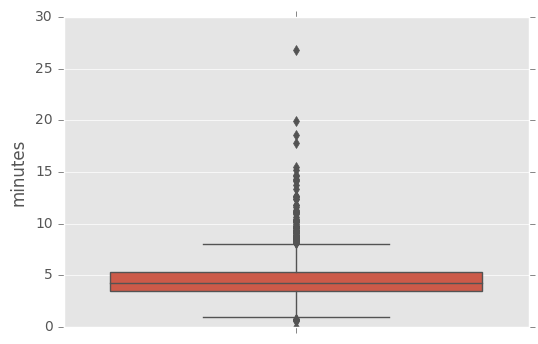

In [24]:
def outlier_detection_using_iqr(data, units):
    """ The function accepts a pandas dataframe and unit of time as parameters and
        returns the upper bound and lower bound of the data calculated using IQR
        outside of which a data point is considered an outlier
    """
    q1,q3 = np.percentile(data, [25,75])
    iqr = q3-q1
    lower_bound= q1 - (iqr*1.5)
    upper_bound = q3 + (iqr *1.5)
    sns.boxplot(x = data, orient='verticle')

    print('The lower bound for this data is --> {0:.2f} {1}, any data point less than this value is considered an Outlier'
          .format(lower_bound, units))
    
    print('The upper bound for this data is --> {0:.2f} {1}, any data point greater than this value is considered an Outlier'
          .format(upper_bound, units))

outlier_detection_using_iqr(rock_track_length_data, "minutes")    

#### The Box-plot which is constructed using the Inter-Quantile-Range shows us that we have outliers on either side of the lower and upper bound, we get a sense that we have a larger number of data points that are greater than upper bound

### 9. Prepare a plot(s) that effectively illustrates the variation of track length by genre.
*use track_facts*

In [25]:
def violin_plot(data, variables_list, variable = None, x = None, y = None, hue = None, palette = None):
    """The function requires the data in the form of pandas dataframe and a list of variables/Categories contained in the column
        of the datafrma and plots Violin plot for just those selected variables. x, y, hue_on : are names of 
        variables in data, palette allows us to use Colors for the different levels of the hue. We can compare variation of any 
        number of variables at a time
        
        - Violin plot for the selected categories within a variable is displayed"""
    
    data = data[data[variable].isin(variables_list)]
    
    sns.violinplot(x = x, y = y, data = data, hue = hue, palette='Dark2', inner = 'quartile')
    

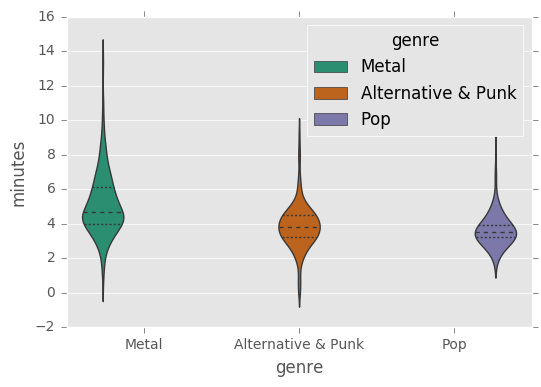

In [26]:
genre_list = ['Metal', 'Alternative & Punk', 'Pop']

violin_plot(track_facts, genre_list, variable = 'genre', x = 'genre', y = 'minutes', hue ='genre', palette='Dark2' )

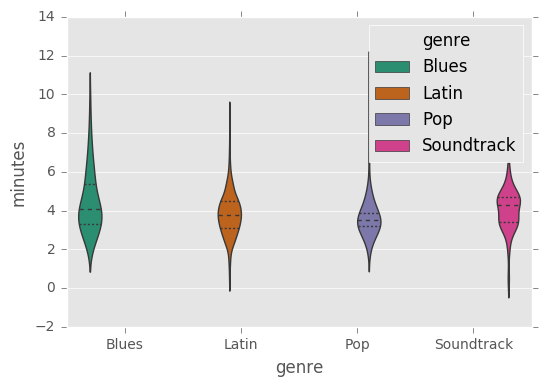

In [27]:
genre_list = ['Blues', 'Latin', 'Pop', 'Soundtrack']

violin_plot(track_facts, genre_list, variable = 'genre', x = 'genre', y = 'minutes', hue ='genre', palette='Dark2' )

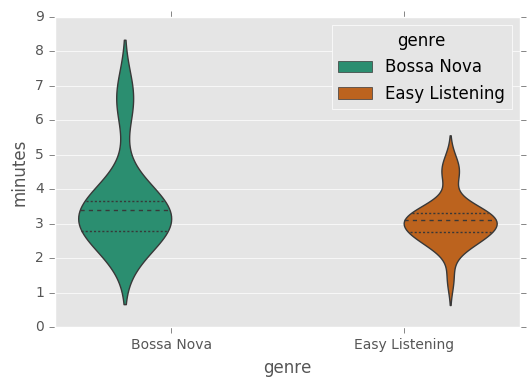

In [28]:
genre_list = ['Bossa Nova','Easy Listening']

violin_plot(track_facts, genre_list, variable = 'genre', x = 'genre', y = 'minutes', hue ='genre', palette='Dark2' )

#### The function efficiently plots the variation filtered based on the 'Genre', any number of categories can be selected from the available column category at a time

### 10. Prepare a plot(s) that summarizes sales by month.
*use orders*

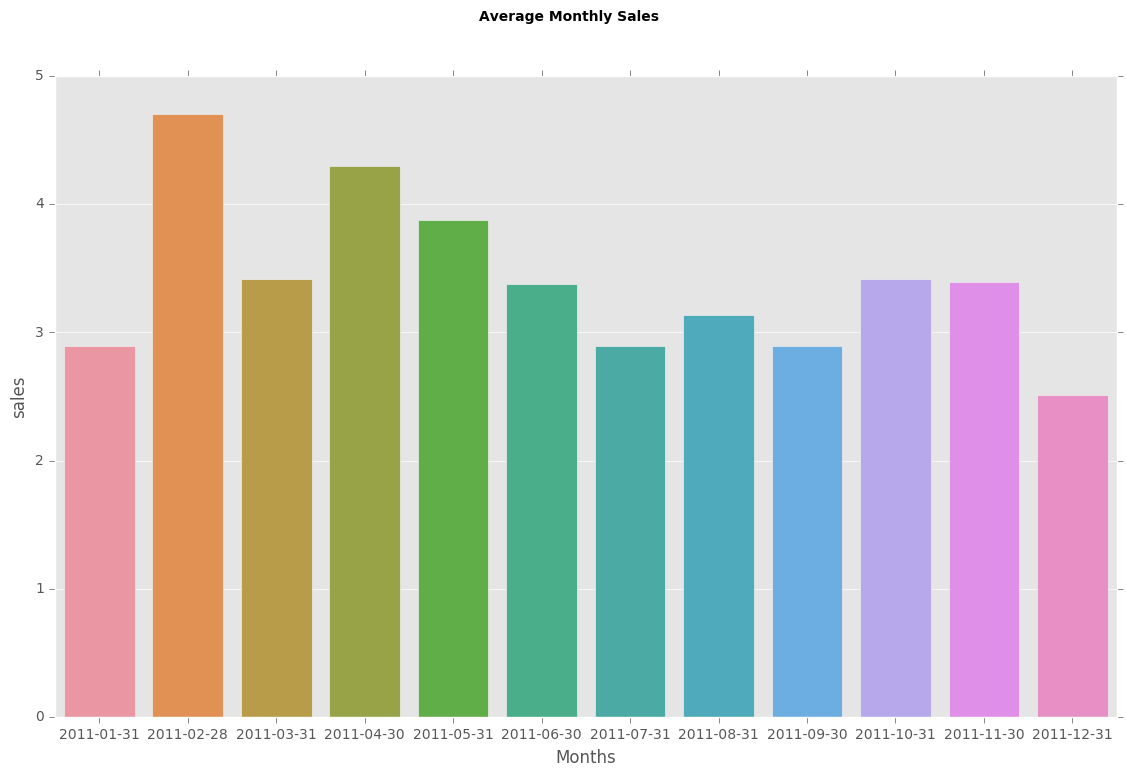

In [29]:
orders = pandas.read_csv("C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/orders.csv")

def monthly_sales_bar_plot(data, date_column, sales, start_date, end_date):
    """ The funcion accepts a pandas dataframe, the name of the variable contataing the sales, date,
        a start data and an end date of the period within which we want to explore the average monthly sales data
    """
    data[date_column] = pandas.to_datetime(data[date_column], infer_datetime_format = True)
    data[date_column] = data[date_column].apply(lambda x: pandas.to_datetime(x).strftime('%m/%Y'))     
    data.set_index(date_column, inplace=True)
    data.index = pandas.to_datetime(data.index)
    resample_monthly_avg_sales = data.resample('m').mean()
    
    filtered_df = resample_monthly_avg_sales[(resample_monthly_avg_sales.index >= start_date) & 
                                             (resample_monthly_avg_sales.index <= end_date)]
    
    a4_dims = (13.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.suptitle("Average Monthly Sales", fontsize=10, fontweight='bold')
    plt.xlabel("Months")
    plt.ylabel("Average Sales")
    
    sns.barplot(x= filtered_df.index.date, y = 'sales', data = filtered_df, ax = ax)

    
monthly_sales_bar_plot(orders, 'invoice_date', 'sales', start_date='2011-01-01', end_date='2012-1-01')

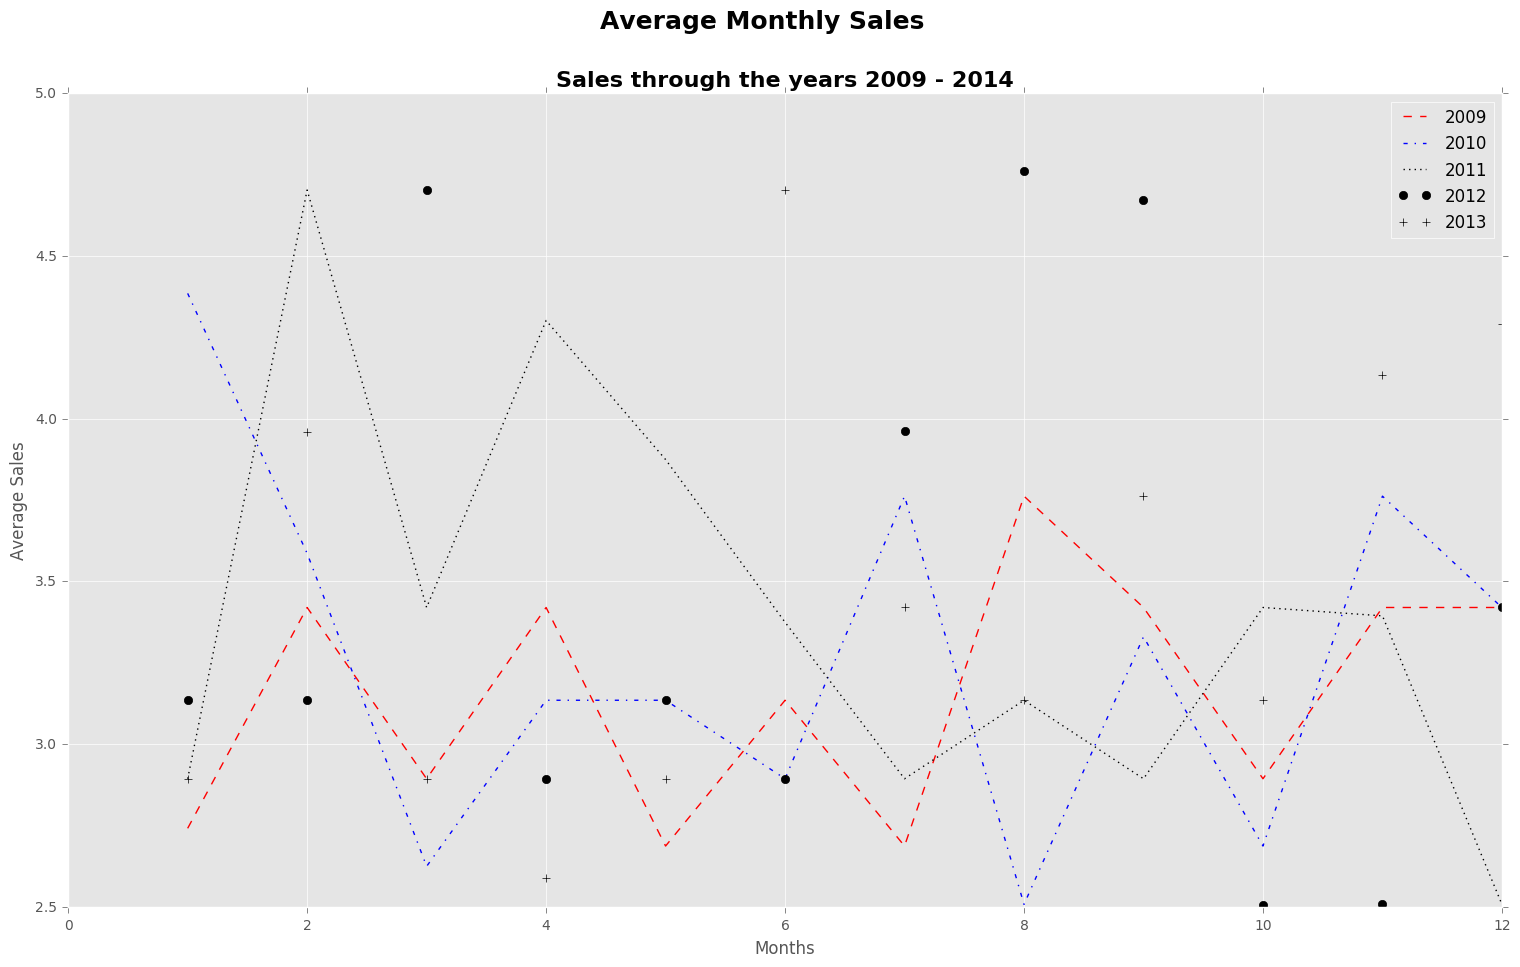

In [30]:
orders = pandas.read_csv("C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/orders.csv")

def monthly_sales_line_plot(data, date_col, sales_col, year_list):
    """ The funcion accepts a pandas dataframe, the name of the variable contataing the sales, date,
        a list of years that we want to inculude in our line graph
        
        returns: A list of lists contaning the monthly average sales data, the number of sub-lists is equal to the number of 
                 years we want the graph for
    """
    data[date_col] = pd.to_datetime(data[date_col])
    yearly_sales = []
    for year in year_list:
        df = data[ data[date_col].dt.year == year]
        df.set_index(date_col, inplace=True)
        yearly_sale_values = df.resample('m').mean()[sales_col]
        yearly_sales.append(list(yearly_sale_values))
    
    return yearly_sales

sales_values = monthly_sales_line_plot(orders, 'invoice_date', 'sales', [2009, 2010,2011,2012,2013])


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

months = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(months, sales_values[0], '--', color = 'red', label = 2009)
plt.plot(months, sales_values[1], '-.',  color = 'blue', label = 2010)
plt.plot(months, sales_values[2], ':', color = 'black',label = 2011)
plt.plot(months, sales_values[3], 'o', color = 'black', label = 2012)
plt.plot(months, sales_values[4], '+', color = 'black',label = 2013)

plt.title("Sales through the years 2009 - 2014", fontsize=16, fontweight='bold')
plt.suptitle("Average Monthly Sales", fontsize=18, fontweight='bold')
plt.xlabel("Months")
plt.ylabel("Average Sales")
        
plt.legend()



### 11. Are there improvements and/or changes you would make to your plots above if your audience was a group of data engineers and data scientists? What about if your audience was from product/marketing and sales?

### 12. We want to build a recommendation service for our customers. 

* What features might be important for predicting whether a customer is likely to purchase a track?
* Create a simple model based on those features and evaluate it's performance.
* How much did those features individually contribute to the predictions of your model?
* How would you explain your model to a Product Manager? To the Sales team?
* What next steps would you take to improve the predictive performance of your model?

### Here are the steps for recommnding tracks and retaining the customers :
#### 1. Merging the various tables and preparing a customer level invoice data with aggregation of columns to get total_invoice_amount, average_invoice_amount, 'total_qty', average_qty_per_invoice, country per customer

#### 2. Building a churn model so we could recapture the customers that are at high risk of churning. Considering the latest invoice date (last transaction) as a label and subtracting it from the second to last invoice date (second last transaction) gives us the difference in days between the last 2 transactions for each customer, if the difference in the customers last  2 transactions is greater than say 240 days we label them as 1 indicating churn and 0 otherwise, we build a simple random forest classifier, evaluate the Kfold accuracy, get the feature importance. We can make custom offers to these custoemers who are predicted as churned to retain them

#### 3. Building a simple recommendation model: using the dummies of tracks i.e a dataframe with index representing customer id and columns representing each tracks with 1 if customer has purchased the track 0 otherwise, we then calculate cosine similarity between a customer and every other customer, get the K similar customers and recommend songs based on the songs of those k similar customers

In [ ]:
#Step 1

In [246]:
customers = pd.read_csv('C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/customers.csv')
invoices = pd.read_csv('C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/invoices.csv')
invoices['invoices.InvoiceDate'] = pd.to_datetime(invoices['invoices.InvoiceDate'])

#The thumb rule for any predicitve modelling is that the test set should always be hidden/independent from the train set
# We take out the last transaction for each customer and discard it from the original data set
last_transaction_invoice_date = invoices.groupby('invoices.CustomerId')['invoices.InvoiceDate'].agg({'labels': np.max}).reset_index()
idx = invoices.groupby('invoices.CustomerId')['invoices.InvoiceDate'].transform(max) != invoices['invoices.InvoiceDate']

#The new invoice dataframe does not include the latest transaction for each cutomer
invoices = invoices[idx]
invoice_items = pd.read_csv('C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/invoice_items.csv')

#Aggregating the Invoice columns
invoice_agg_price = invoice_items.groupby('invoice_items.InvoiceId')['invoice_items.UnitPrice'].agg({'invoice_unitPrice_avg': np.mean, 
                                                                                'invoice_unitPrice_total': np.sum}).reset_index()
invoice_agg_qty = invoice_items.groupby('invoice_items.InvoiceId')['invoice_items.Quantity'].agg({'total_qty': np.sum}).reset_index()
invoice_agg_data = pd.merge(invoice_agg_price, invoice_agg_qty, on = 'invoice_items.InvoiceId')
invoice_level_data = pd.merge(invoices, invoice_agg_data, left_on = 'invoices.InvoiceId', right_on='invoice_items.InvoiceId')
customer_total_price = invoice_level_data.groupby('invoices.CustomerId')['invoice_unitPrice_total'].agg({'total_invoice_amount': np.sum,
                                                                                'average_invoice_amount': np.mean}).reset_index()
customer_total_qty = invoice_level_data.groupby('invoices.CustomerId')['total_qty'].agg({'total_qty': np.sum, 'average_qty_per_invoice': np.mean}).reset_index()
customer_country = invoice_level_data.groupby('invoices.CustomerId')['invoices.BillingCountry'].agg({'country': lambda x:x.value_counts().index[0]}).reset_index()
customer_level_invoice_data = pd.merge(customer_total_price, customer_total_qty, on= 'invoices.CustomerId')
customer_level_invoice_data = pd.merge(customer_level_invoice_data, customer_country, on= 'invoices.CustomerId')

# We then get the second last transaction of invoice data for each customer (The last transaction in our filtered invoice dataframe)
last_transaction_df = invoices.groupby('invoices.CustomerId')['invoices.InvoiceDate'].agg({'last_transaction_train':np.max}).reset_index()

customer_level_invoice_data = pd.merge(customer_level_invoice_data, last_transaction_invoice_date, on = 'invoices.CustomerId')
customer_level_invoice_data = pd.merge(customer_level_invoice_data, last_transaction_df, on = 'invoices.CustomerId')
customer_level_invoice_data.rename(columns={'invoices.CustomerId': 'Customer_ID'}, inplace= True)

In [247]:
customer_level_invoice_data

,Customer_ID,average_invoice_amount,total_invoice_amount,average_qty_per_invoice,total_qty,country,labels,last_transaction_train
0,1,5.118333,30.71,4.833333,29,Brazil,2013-08-07,2012-12-07
1,2,6.105000,36.63,6.166667,37,Germany,2012-07-13,2011-11-23
2,3,6.438333,38.63,6.166667,37,Canada,2013-09-20,2013-01-30
3,4,6.273333,37.64,6.000000,36,Norway,2013-10-03,2012-02-27
4,5,5.285000,31.71,4.833333,29,Czech Republic,2013-05-06,2012-09-05
5,6,3.960000,23.76,4.000000,24,Czech Republic,2013-11-13,2013-10-03
6,7,6.938333,41.63,6.166667,37,Austria,2013-06-19,2012-10-29
7,8,5.610000,33.66,5.666667,34,Belgium,2013-10-04,2013-07-02
8,9,4.785000,28.71,4.833333,29,Denmark,2013-02-02,2012-06-04
9,10,3.960000,23.76,4.000000,24,Brazil,2013-08-12,2013-07-02


In [374]:
customer_level_invoice_data['Date_diff_btw_transactions'] = (customer_level_invoice_data['labels'] - customer_level_invoice_data['last_transaction_train']).dt.days

# A customer who had a difference of greater than a threshold number of days (ex. 240) is labelled as 1 indicating Churn
customer_level_invoice_data['Churned'] = np.where(customer_level_invoice_data['Date_diff_btw_transactions'] > 240, 1, 0)

customer_level_invoice_data

,Customer_ID,average_invoice_amount,total_invoice_amount,average_qty_per_invoice,total_qty,country,labels,last_transaction_train,Date_diff_btw_transactions,Churned
0,1,5.118333,30.71,4.833333,29,Brazil,2013-08-07,2012-12-07,243,1
1,2,6.105000,36.63,6.166667,37,Germany,2012-07-13,2011-11-23,233,0
2,3,6.438333,38.63,6.166667,37,Canada,2013-09-20,2013-01-30,233,0
3,4,6.273333,37.64,6.000000,36,Norway,2013-10-03,2012-02-27,584,1
4,5,5.285000,31.71,4.833333,29,Czech Republic,2013-05-06,2012-09-05,243,1
5,6,3.960000,23.76,4.000000,24,Czech Republic,2013-11-13,2013-10-03,41,0
6,7,6.938333,41.63,6.166667,37,Austria,2013-06-19,2012-10-29,233,0
7,8,5.610000,33.66,5.666667,34,Belgium,2013-10-04,2013-07-02,94,0
8,9,4.785000,28.71,4.833333,29,Denmark,2013-02-02,2012-06-04,243,1
9,10,3.960000,23.76,4.000000,24,Brazil,2013-08-12,2013-07-02,41,0


In [ ]:
#Step2

### Building the churn model

In [375]:
modelling_data = customer_level_invoice_data[['total_invoice_amount', 'average_invoice_amount',
       'total_qty', 'average_qty_per_invoice', 'country', 'Churned']]

In [376]:
print('Total Null Values by each variable:\n', modelling_data.isnull().sum())
print('\nNo of Duplicated records:', modelling_data.duplicated().sum())

print('Dropping duplicates ...')
modelling_data.drop_duplicates(inplace=True)


Total Null Values by each variable:
 total_invoice_amount       0
average_invoice_amount     0
total_qty                  0
average_qty_per_invoice    0
country                    0
Churned                    0
dtype: int64

No of Duplicated records: 5
Dropping duplicates ...


In [377]:
#Removing Outliers using Standard Deviation
def filtering_outliers_using_n_standard_deviation(data, num_cols_list = [], n = 2):
    """ Remove rows which are n standard deviations from the mean
        Return: Filtered Dataframe
    """

    for col in data.columns:
        if col in num_cols_list:
            mean = data[col].mean()
            std = data[col].std()
            upper = mean + abs(n) * std
            lower = mean - abs(n) * std
            bad_idx_list = []
            bad_idx = data[(data[col] >= upper) | (data[col] <= lower)].index
            bad_idx_list.append(bad_idx)
            flat_list = [item for sublist in bad_idx_list for item in sublist]
            clean_data = data.loc[~data.index.isin(bad_idx)]

    return clean_data

print('Shape before Outlier Filtering: ', modelling_data.shape)

clean_data = filtering_outliers_using_n_standard_deviation(modelling_data, num_cols_list = ['total_invoice_amount', 'average_invoice_amount',
       'total_qty', 'average_qty_per_invoice'], n = 1.5)

print('\nShape after Outlier Filtering: ', clean_data.shape)


Shape before Outlier Filtering:  (54, 6)

Shape after Outlier Filtering:  (47, 6)


In [378]:
def encoding_categorical_cols(data, encode_cols_list = [], one_hot_encode_list = []):
    """ Encode categorical columns using one hot encoding or Label encoding
    
        Return: Encoded dataframe
    """
    
    for col in encode_cols_list:
        label_encode = LabelEncoder()
        data[col] = label_encode.fit_transform(data[col].astype(str))

    if col in one_hot_encode_list:
        data = pd.get_dummies(data, columns = one_hot_encode_list)

    return data

In [379]:
encoded_data = encoding_categorical_cols(clean_data, encode_cols_list = ['country'])

In [380]:
#Creating features and labels for our model
x = encoded_data[['total_invoice_amount', 'average_invoice_amount', 'total_qty',
       'average_qty_per_invoice', 'country']]

y = encoded_data['Churned']

In [266]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rfc = RandomForestClassifier()

kfold = KFold(n_splits=5, random_state=99)
results = cross_val_score(rfc, x, y, cv=kfold, scoring='accuracy', verbose=3)
print("\n Accuracy: %.2f | Variation of Accuracy for the folds(%.2f) " % (results.mean(), results.std()))

[CV]  ................................................................
[CV] ...................................... , score=0.9, total=   0.0s
[CV]  ................................................................
[CV] ...................................... , score=0.8, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8888888888888888, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8888888888888888, total=   0.0s
[CV]  ................................................................
[CV] ...................................... , score=1.0, total=   0.0s

 Accuracy: 0.90 | Variation of Accuracy for the folds(0.06) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [383]:
def feature_importance(data, target = None):
        model = RandomForestRegressor(100, oob_score = True, random_state =99)
        features = data.drop(columns=[target])
        labels = data[target]
        model.fit(features,labels)
        feature_importance = pd.Series(model.feature_importances_, index = features.columns)
        feature_importance.plot( kind = 'barh', figsize = (7,6));



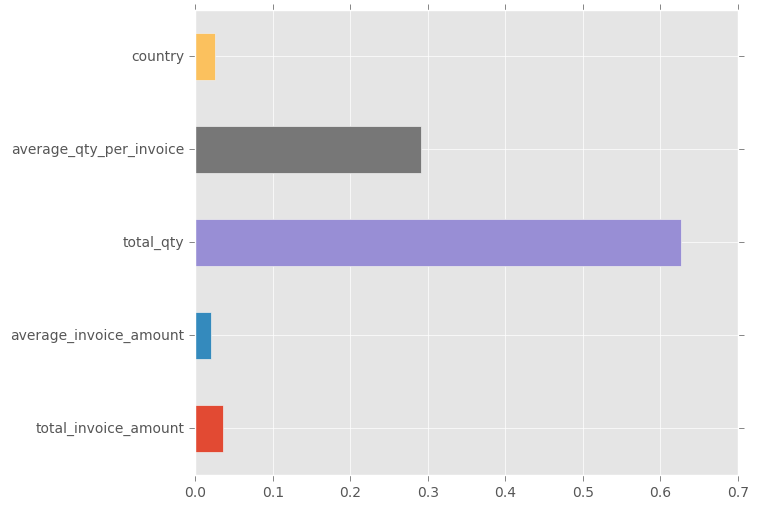

In [384]:
df = feature_importance(encoded_data, target = 'Churned')

2. Create a simple model based on those features and evaluate its performance?

We created a churn model and achieved a CV accuracy of 90% using Random Forest Classifier

In [ ]:
3. How much did those features individually contribute to the predictions of your model?

Total Quantity, Average quantity per invoice for a customer were the most important features according to Random forest Regressor

In [385]:
#Step3

## Building a simple recommendation Engine

In [273]:
# Reading the files
customers = pd.read_csv('C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/customers.csv')
invoices = pd.read_csv('C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/invoices.csv')
invoice_items = pd.read_csv('C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/invoice_items.csv')
tracks = pd.read_csv('C:/Users/Shrinivas Kallol/Technical Assessment DS/Technical Assessment DS/db/csv/tracks.csv')

In [13]:
# Merging the files
cutomers_invoices = pd.merge(customers, invoices, left_on='customers.CustomerId', right_on='invoices.CustomerId' )
cutomers_invoices_invoice_items = pd.merge(cutomers_invoices, invoice_items, left_on='invoices.InvoiceId', right_on='invoice_items.InvoiceId' )
cutomers_invoices_invoice_items_tracks = pd.merge(cutomers_invoices_invoice_items, tracks, left_on='invoice_items.TrackId', 
                                                  right_on='tracks.TrackId')

In [358]:
# The pivoted dataframe consists of customer_id as index and dummy encoded tracks as columns with 1 indicating a purchase, 0 otherwise
pivoted_df = pd.pivot_table(selected_cols, index='customers.CustomerId', columns='tracks.TrackId', aggfunc=len, fill_value=0)

In [354]:
# Computing User-User similarity using cosine similarity
user_user_similarity_df = pd.DataFrame(cosine_similarity(pivoted_df))
user_user_similarity_df

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.078947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.078947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078947,0.000000,0.000000
6,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.078947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [366]:
def get_recommendation(customer_id):
    """ Takes in customer id as a parameter and prints out the recommended track id based on the most similar user"""
    tracks = []
    for customer_index in dff[customer_id - 1].nlargest(2).index.tolist():
        customer_index = customer_index + 1
        tracks.append(cutomers_invoices_invoice_items_tracks[cutomers_invoices_invoice_items_tracks['customers.CustomerId'] == customer_index]['tracks.TrackId'].tolist())
    
    recommended_tracks = np.ravel(tracks)
    recommended_tracks = set(recommended_tracks) - set(cutomers_invoices_invoice_items_tracks[cutomers_invoices_invoice_items_tracks['customers.CustomerId'] == customer_id]['tracks.TrackId'].tolist())
    
    print('Recommended tracks for the customer_id: {} ----> track_id: {}'.format(customer_id, recommended_tracks ))


In [371]:
get_recommendation(1)

Recommended tracks for the customer_id: 1 ----> track_id: {2561, 2565, 1672, 1681, 274, 1690, 286, 1699, 292, 1708, 1325, 1327, 304, 1841, 1839, 1843, 1845, 310, 1717, 1726, 322, 1735, 1744, 1753, 1762, 1771, 1136, 1137, 2545, 880, 2549, 1654, 2553, 2557, 1663}


In [369]:
# Evaluating the performance of our simple Recommender

In [370]:
cutomers_invoices_invoice_items_tracks[cutomers_invoices_invoice_items_tracks['customers.CustomerId'] == 1]['tracks.GenreId'].value_counts() 

1     14
7     11
8      3
24     2
20     2
10     2
9      2
3      2
Name: tracks.GenreId, dtype: int64

#### We check the value counts of tracks for customer_id 1, we see that the customer likes Genre Id 1, 7 the most 

In [372]:
recommended_tracks = [2561, 2565, 1672, 1681, 274, 1690, 286, 1699, 292, 1708, 1325, 1327, 304, 1841, 1839, 1843, 1845, 310, 1717, 1726, 322, 1735, 1744, 1753, 1762, 1771, 1136, 1137, 2545, 880, 2549, 1654, 2553, 2557, 1663]

In [373]:
cutomers_invoices_invoice_items_tracks[cutomers_invoices_invoice_items_tracks['tracks.TrackId'].isin(recommended_tracks)]['tracks.GenreId'].value_counts() 

7    16
3    10
1    10
8     4
4     2
Name: tracks.GenreId, dtype: int64

#### We check for the value counts of tracks recommended for customer_id 1,we see that the recommended tracks for the customer 1 are mostly from Genre 7, 3, 1 which customer 1 likes

### 13. Take a look at the following plot from the Economist on the relationship between corruption and development of countries. 

![](https://cdn.static-economist.com/sites/default/files/20111210_WOC210.gif)

* What aspects of the plot work well?
* What would you change about it to be more effective?

### The ascpects that work well:
#### 1. The plot accomodates a lot of information within one plot, the best fit line gives us a sense of the the relationship between corruption and development of countries
#### 2. The color coding by region makes sense as one can assume that countries close to each other have similar climatic conditions, history, and influence each other to a certain degree 

### The plot could be much more effective if
#### 1. The color selected for the regions were much more distinct, Americas and Asia & Oceania are difficult to distinguish
#### 2. There were better rules defined for displaying the country names, the plot misses out on a lot of countries if the cluster is dense